In [ ]:
!pip install ipympl

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 511.6/511.6 kB 3.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 60.3 MB/s eta 0:00:00


In [373]:
%matplotlib ipympl
import numpy as np
import matplotlib.pyplot as plt
from typing import Literal
import torch
from torch import nn
from torch.autograd import Variable
from pandas import DataFrame
# from google.colab import output
# output.enable_custom_widget_manager()

In [380]:
with plt.ioff():
    fig, (ax, ax2) = plt.subplots(2)

In [258]:
def generate_xor(N: int, noise: int):
    def get_xor_label(x, y):
        return 1 if x * y >= 0 else -1

    get_xor_label = np.vectorize(get_xor_label)
    padding = .3
    x = np.random.uniform(-5, 5, N)
    x += np.where(x > 0, padding, -padding)
    y = np.random.uniform(-5, 5, N)
    y += np.where(y > 0, padding, -padding)
    noise_x = np.random.uniform(-5, 5, N) * noise
    noise_y = np.random.uniform(-5, 5, N) * noise
    labels = np.where((x + noise_x) * (y + noise_y) >= 0, 1, -1)
    # labels = get_xor_label(x + noise_x, y + noise_y)
    return x, y, labels

def generate_spiral(N: int, noise: int):
    n = N // 2

    def gen_sigle_spiral(delta_t: int, label: int):
        r = np.arange(n) / n * 5
        t = 1.75 * np.arange(n) / n * 2 * np.pi + delta_t
        x = r * np.sin(t) + np.random.uniform(-1, 1, n) * noise
        y = r * np.cos(t) + np.random.uniform(-1, 1, n) * noise
        return x, y, np.full(n, label)

    one = gen_sigle_spiral(0, 1)
    second = gen_sigle_spiral(np.pi, -1)

    x = np.concatenate([one[0], second[0]])
    y = np.concatenate([one[1], second[1]])
    labels = np.concatenate([one[2], second[2]])
    return x, y, labels

def generate_circle(N: int, noise: int):
    if N == 0:
        return np.array([]), np.array([]), np.array([])
    n = N // 2
    radius = 5

    def dist(x, y, center_x, center_y):
        return np.sqrt((x - center_x) ** 2 + (y - center_y) ** 2)
    dist = np.vectorize(dist)

    def get_circle_label(x, y, center_x, center_y):
        return 1 if dist(x, y, center_x, center_y) <= radius / 2 else -1
    get_circle_label = np.vectorize(get_circle_label)

    r = np.concatenate((np.random.uniform(0, radius / 2, n), (np.random.uniform(radius * .7, radius, n))))
    angle = np.random.uniform(0, 2 * np.pi, n * 2)
    x = r * np.sin(angle)
    noise_x = np.random.uniform(-radius, radius, n * 2) * noise
    y = r * np.cos(angle)
    noise_y = np.random.uniform(-radius, radius, n * 2) * noise
    labels = get_circle_label(x + noise_x, y + noise_y, 0, 0)

    return x, y, labels

def generate_two_gauss(N: int, noise: int):
    n = N // 2
    variance_scale = np.vectorize(lambda x: .5 + 3.5 * (x / .5))
    variance = variance_scale(noise)

    x = np.concatenate((np.random.normal(2, variance, n), np.random.normal(-2, variance, n)))
    y = np.concatenate((np.random.normal(2, variance, n), np.random.normal(-2, variance, n)))
    labels = np.concatenate((np.full(n, 1), np.full(n, -1)))
    return x, y, labels

In [382]:
def generate_points(N: int, test_percent, noise: int, *funcs):
    global x_train, y_train, labels_train, x_test, y_test, labels_test, train_data, test_data
    test_count = int(N * test_percent)
    x_train, y_train, labels_train, x_test, y_test, labels_test, train_data, test_data = [], [], [], [], [], [], [], []
    for func in funcs:
        x, y, l = func(N, noise)
        x_train.append(x)
        y_train.append(y)
        labels_train.append(l)
        x, y, l = func(test_count, noise)
        x_test.append(x)
        y_test.append(y)
        labels_test.append(l)
        # x_train, y_train, labels_train = func(N, noise)
        # train_data = np.array([x_train, y_train]).T
        # x_test, y_test, labels_test = func(test_count, noise)
        # test_data = np.array([x_test, y_test]).T
    x_train = np.concatenate(x_train)
    y_train = np.concatenate(y_train)
    labels_train = np.concatenate(labels_train)
    x_test = np.concatenate(x_test)
    y_test = np.concatenate(y_test)
    labels_test = np.concatenate(labels_test)
    train_data = np.array([x_train, y_train]).T
    test_data = np.array([x_test, y_test]).T
    


In [421]:
generate_points(200, 1, 0.3, generate_spiral)
# ax.clear()
# ax.scatter(x_train, y_train, c=labels_train)
# fig

In [422]:

#500
#act = nn.Sigmoid
#lr = 1
#500
#act = nn.ReLU
#lr = 0.01
#300
act = nn.Tanh
lr = 0.01

model = nn.Sequential(
    nn.Linear(2, 8),
    act(),
    nn.Linear(8, 8),
    act(),
    nn.Linear(8, 1),
    act(),
)
# er_f = nn.HuberLoss()
er_f = nn.BCELoss()
optim = torch.optim.SGD(model.parameters(), lr=lr)

In [429]:

x_train =torch.tensor(train_data)
y_train = torch.tensor((labels_train + 1) // 2)
for _ in range(10000):
    optim.zero_grad()
    train = Variable(x_train.float(), requires_grad=True)
    target = Variable(y_train.float(), requires_grad=False)
    out = model(train)
    loss = er_f(out.squeeze().clamp(0, 1), target)
    # loss = (out - target).mean()
    loss.backward()
    optim.step()
print(loss)

tensor(0.0726, grad_fn=<BinaryCrossEntropyBackward0>)


0.865 173 200


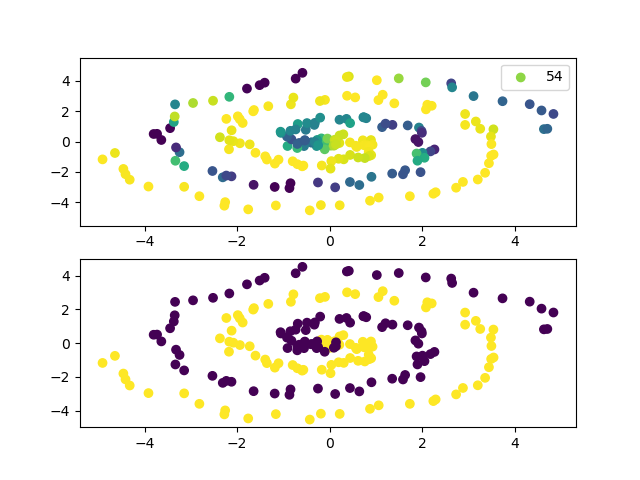

In [431]:
error_torch = 0
right = 0
predicted_labels = list()
for data, label in zip(test_data, labels_test):
    ptep = ((model(torch.tensor(data).float()) + 1) / 2).detach().clamp(0, 1).numpy()
    predicted_labels.append(ptep)
    ptep = 1 if ptep > .5 else -1
    right += ptep == label
    error_torch += abs(ptep - label)
print(right / len(labels_test), right, len(labels_test))
x_line = np.linspace(x_test.min(), x_test.max(), 20)
ax.clear()
ax2.clear()
pred_points = ax.scatter(x_test, y_test, c=predicted_labels, label=f"{error_torch}")
ax2.scatter(x_test, y_test, c=labels_test)
# pred_points.set_visible(False)
ax.set_ylim(y_test.min() - 1, y_test.max() + 1)
ax.legend()
plt.show(fig)

# Cross validation

In [366]:
acts = (nn.Sigmoid, nn.ReLU, nn.Tanh)
lr = (1, 0.01, 0.01)

models = tuple(nn.Sequential(
    nn.Linear(2, 8),
    act(),
    nn.Linear(8, 8),
    act(),
    nn.Linear(8, 1),
    act(),
) for act in acts)
# er_f = nn.HuberLoss()
er_f = nn.BCELoss()
optims = tuple(torch.optim.SGD(model.parameters(), lr=lr) for model, lr in zip(models, lr))
for i, model in enumerate(models):
    torch.save(model.state_dict(), f'model{i}.pth')
models

(Sequential(
   (0): Linear(in_features=2, out_features=8, bias=True)
   (1): Sigmoid()
   (2): Linear(in_features=8, out_features=8, bias=True)
   (3): Sigmoid()
   (4): Linear(in_features=8, out_features=1, bias=True)
   (5): Sigmoid()
 ),
 Sequential(
   (0): Linear(in_features=2, out_features=8, bias=True)
   (1): ReLU()
   (2): Linear(in_features=8, out_features=8, bias=True)
   (3): ReLU()
   (4): Linear(in_features=8, out_features=1, bias=True)
   (5): ReLU()
 ),
 Sequential(
   (0): Linear(in_features=2, out_features=8, bias=True)
   (1): Tanh()
   (2): Linear(in_features=8, out_features=8, bias=True)
   (3): Tanh()
   (4): Linear(in_features=8, out_features=1, bias=True)
   (5): Tanh()
 ))

In [367]:
generate_points(800, 0, .3, generate_spiral)

In [369]:
errors = [0] * len(models)
x_train_sets =torch.tensor(train_data).split(len(x_train) // len(models))
y_train_sets = torch.tensor((labels_train + 1) // 2).split(len(y_train) // len(models))
for k in range(len(x_train_sets)):
    x_train_set = torch.cat(x_train_sets[:k] + x_train_sets[k + 1:])
    y_train_set = torch.cat(y_train_sets[:k] + y_train_sets[k + 1:])
    x_test_set = x_train_sets[k]
    y_test_set = y_train_sets[k]
    for i, (model, optim) in enumerate(zip(models, optims)):
        model.load_state_dict(torch.load(f'model{i}.pth'))
        for _ in range(3000):
            optim.zero_grad()
            train = Variable(x_train_set.float(), requires_grad=True)
            target = Variable(y_train_set.float(), requires_grad=False)
            out = model(train)
            loss = er_f(out.squeeze().clamp(0, 1), target)
            # loss = (out - target).mean()
            loss.backward()
            optim.step()
        errors[i] += er_f(model(x_test_set.float()).squeeze().clamp(0, 1), y_test_set.float()).detach().item()
DataFrame(np.array([acts, errors]).T, columns=['functions', 'error'])

,functions,error
0,<class 'torch.nn.modules.activation.Sigmoid'>,52.87839
1,<class 'torch.nn.modules.activation.ReLU'>,293.367191
2,<class 'torch.nn.modules.activation.Tanh'>,155.543029


# layers.MPEG

In [370]:
from itertools import chain
act = nn.Sigmoid
lr = 1

layers_num = (1, 2, 3, 4, 5)

models = tuple(nn.Sequential(
    nn.Linear(2, 8),
    act(),
    *chain(*((nn.Linear(8, 8), act()) for _ in range(n))),
    nn.Linear(8, 1),
    act(),
) for n in layers_num)
# er_f = nn.HuberLoss()
er_f = nn.BCELoss()
optims = tuple(torch.optim.SGD(model.parameters(), lr=lr) for model in models)
for i, model in enumerate(models):
    torch.save(model.state_dict(), f'model{i}.pth')
models

(Sequential(
   (0): Linear(in_features=2, out_features=8, bias=True)
   (1): Sigmoid()
   (2): Linear(in_features=8, out_features=8, bias=True)
   (3): Sigmoid()
   (4): Linear(in_features=8, out_features=1, bias=True)
   (5): Sigmoid()
 ),
 Sequential(
   (0): Linear(in_features=2, out_features=8, bias=True)
   (1): Sigmoid()
   (2): Linear(in_features=8, out_features=8, bias=True)
   (3): Sigmoid()
   (4): Linear(in_features=8, out_features=8, bias=True)
   (5): Sigmoid()
   (6): Linear(in_features=8, out_features=1, bias=True)
   (7): Sigmoid()
 ),
 Sequential(
   (0): Linear(in_features=2, out_features=8, bias=True)
   (1): Sigmoid()
   (2): Linear(in_features=8, out_features=8, bias=True)
   (3): Sigmoid()
   (4): Linear(in_features=8, out_features=8, bias=True)
   (5): Sigmoid()
   (6): Linear(in_features=8, out_features=8, bias=True)
   (7): Sigmoid()
   (8): Linear(in_features=8, out_features=1, bias=True)
   (9): Sigmoid()
 ),
 Sequential(
   (0): Linear(in_features=2, out_fe

In [371]:
generate_points(600, 0, .3, generate_spiral)

In [372]:
errors = [0] * len(models)
x_train_sets =torch.tensor(train_data).split(len(x_train) // len(models))
y_train_sets = torch.tensor((labels_train + 1) // 2).split(len(y_train) // len(models))
for k in range(len(x_train_sets)):
    x_train_set = torch.cat(x_train_sets[:k] + x_train_sets[k + 1:])
    y_train_set = torch.cat(y_train_sets[:k] + y_train_sets[k + 1:])
    x_test_set = x_train_sets[k]
    y_test_set = y_train_sets[k]
    for i, (optim, model) in enumerate(zip(optims, models)):
        model.load_state_dict(torch.load(f'model{i}.pth'))
        for _ in range(5000):
            optim.zero_grad()
            train = Variable(x_train_set.float(), requires_grad=True)
            target = Variable(y_train_set.float(), requires_grad=False)
            out = model(train)
            loss = er_f(out.squeeze().clamp(0, 1), target)
            # loss = (out - target).mean()
            loss.backward()
            optim.step()
        errors[i] += er_f(model(x_test_set.float()).squeeze().clamp(0, 1), y_test_set.float()).detach().item()
DataFrame(np.array([layers_num, errors]).T, columns=['layers_num', 'error'])

,layers_num,error
0,1.0,61.607486
1,2.0,48.735301
2,3.0,22.755650
3,4.0,8.976296
4,5.0,4.616475
